In [1]:
import pandas as pd
import numpy as np
np.random.seed(11)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
"""
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Clean and Merge Datasets (Eren)

In [2]:
# Enter data paths for raw_text version and parsed_text version
data_raw = "../data/reviews_raw.json"
data_parsed = "../data/reviews_parsed.json"

data_with_raw = pd.read_json(data_raw, lines=True)
data_with_parsed = pd.read_json(data_parsed, lines=True)

In [3]:
new_df = pd.merge(data_with_parsed, data_with_raw, on=["review_id"])


In [4]:
new_df = new_df.rename(columns={"rating_x": "rating", "user_id_x": "user_id", "rating_x": "rating",
                       "book_id_x": "book_id",})
selected_cols = ["user_id", "book_id", "review_sentences", "rating", 
                 "timestamp", "n_votes", "n_comments", "has_spoiler"]
new_df = new_df[selected_cols]

In [5]:
new_df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
0,8842281e1d1347389f2ab93d60773d4d,18245960,"[[0, This is a special book.], [0, It started ...",5,2017-08-30,28,1,True
1,8842281e1d1347389f2ab93d60773d4d,16981,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,2017-03-22,1,0,False
2,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
3,8842281e1d1347389f2ab93d60773d4d,27161156,"[[0, Recommended reading to understand what is...",0,2016-11-09,5,1,False
4,8842281e1d1347389f2ab93d60773d4d,25884323,"[[0, I really enjoyed this book, and there is ...",4,2016-04-25,9,1,True


In [6]:
# Dataset reduction

print(f"number of unique books at the beginning: {new_df.book_id.nunique()}")

select_number = 15000
random_books = np.random.choice(new_df.book_id.unique().tolist(), size=select_number)
reduced_df = new_df[new_df.book_id.isin(random_books)]

print(f"number of unique books at the end: {reduced_df.book_id.nunique()}")

print(f"Shape at the end: {reduced_df.shape}")

number of unique books at the beginning: 25475
number of unique books at the end: 11339
Shape at the end: (604686, 8)


In [7]:
print(f"ratio of non-spoiler labels: {reduced_df.has_spoiler.value_counts()[0] / len(reduced_df)}%")

ratio of non-spoiler labels: 0.9344783904373509%


In [8]:
reduced_df.to_json("../data/reduced.json")

In [9]:
df = pd.read_json("../data/reduced.json")

# dikkat = indexler eski datadaki gibi kalmış yani 1 2 5 7 8 diye gidiyor. todo: düzelt bunu

In [10]:

#df = reduced_df

In [11]:
df.head()

,user_id,book_id,review_sentences,rating,timestamp,n_votes,n_comments,has_spoiler
1,8842281e1d1347389f2ab93d60773d4d,16981,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,2017-03-22,1,0,False
2,8842281e1d1347389f2ab93d60773d4d,28684704,"[[0, A fun, fast paced science fiction thrille...",3,2017-03-20,22,0,True
5,8842281e1d1347389f2ab93d60773d4d,19398490,"[[0, A beautiful story.], [0, It is rare to en...",4,2016-09-20,35,5,False
7,8842281e1d1347389f2ab93d60773d4d,24189224,"[[0, Numerous people in publishing have told m...",0,2015-05-29,11,5,False
8,8842281e1d1347389f2ab93d60773d4d,22551730,"[[0, Another hard to put down nonfiction book ...",4,2016-12-14,20,6,False


In [12]:
df.shape

(604686, 8)

## Preprocess review_text (Melisa)

In [13]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def process_review_text(val):
    clean_test = []
    for sentence in val:
        # Tokenize the sentence
        words = word_tokenize(sentence[1])
        # Lowercase and remove non-alphanumeric characters
        words = [word.lower() for word in words if word.isalnum()]
        # Remove stopwords 
        words = [word for word in words if word not in stop_words]
        # Append the cleaned sentence to the cleaned dataset
        
        #LEMMATIZATION ÇOK BİR ŞEY DEĞİŞTİRMİYOR, YETERLİ Mİ YOKSA STEMMİNG Mİ YAPMALIYIZ? İLERDE DURUMA GÖRE BURAYA GERİ DÖN
        normalized_words = [lemmatizer.lemmatize(word) for word in words]
        clean_test.append(normalized_words)
        
    
    # Build a vocabulary
    vocab = set(word for sentence in clean_test for word in sentence)
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # NUMERICAL REPRESENTATION
    numerical_data = [[word_to_index[word] for word in sentence] for sentence in clean_test]
    
    
    # Padding sequences / BAŞLANGIÇ OLARAK 13 SEÇTİM AMA CÜMLE UZUNLUĞU MEANİ 8, OLABİLDİĞİNCE ACCURATE OLSUN DİYE. EĞER HIZDAN DOLAYI
    # SIKINTI YAŞAMAYA BAŞLARSAK BURAYI 8-13 ARASI GİTTİKÇE AŞAĞI ÇEKEBİLİRİZ.
    max_sequence_length = 13
    padded_data = [seq[:max_sequence_length] + [0] * max(0, max_sequence_length - len(seq)) for seq in numerical_data]
    
    
    padded_data = torch.tensor(padded_data)
    #print(padded_data)

    #SPOILER LABELS
    label_lst = [i[0] for i in val]
    labels = torch.tensor(label_lst)

    dataset = TensorDataset(padded_data, labels)
        
    return dataset

In [14]:

# WORKING ON A SMALL SUBSET FOR NOW JUST TO MAKE SURE EVERYTHING WORKS
smaller_df = df.iloc[:20000]
#print(smaller_df.shape)
#print(df["review_sentences"])


smaller_df["test"] = smaller_df["review_sentences"].apply(process_review_text)
#print(smaller_df["test"].describe)


<ipython-input-14-190aa2118ed0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df["test"] = smaller_df["review_sentences"].apply(process_review_text)


In [15]:
print(smaller_df["test"][1])

## Basic Data Analysis (Melisa)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604686 entries, 1 to 1378030
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           604686 non-null  object        
 1   book_id           604686 non-null  int64         
 2   review_sentences  604686 non-null  object        
 3   rating            604686 non-null  int64         
 4   timestamp         604686 non-null  datetime64[ns]
 5   n_votes           604686 non-null  int64         
 6   n_comments        604686 non-null  int64         
 7   has_spoiler       604686 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 37.5+ MB


In [21]:
df.describe()
#n_votes ve n_comments'ın minimum'u negatif olabilir mi? n_votes belki downvote vardır da n_commentsın -1 olması saçma. belki temizlemeliyiz

,book_id,rating,n_votes,n_comments
count,6.046860e+05,604686.000000,604686.000000,604686.000000
mean,1.340981e+07,3.682816,3.120848,0.948552
std,9.305238e+06,1.255711,17.938103,5.226647
min,2.000000e+00,0.000000,-2.000000,-1.000000
25%,6.419850e+06,3.000000,0.000000,0.000000
50%,1.324440e+07,4.000000,0.000000,0.000000
75%,2.049318e+07,5.000000,2.000000,0.000000
max,3.630763e+07,5.000000,3222.000000,660.000000


In [24]:
df.isna().values.any()

False

<AxesSubplot:xlabel='rating', ylabel='n_votes'>

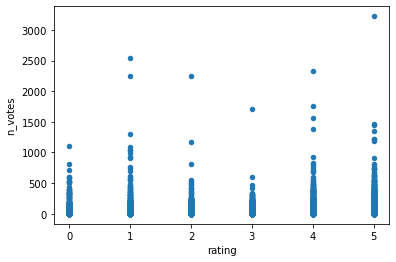

In [25]:
df.plot(kind='scatter', x='rating', y='n_votes')

<AxesSubplot:xlabel='rating', ylabel='n_comments'>

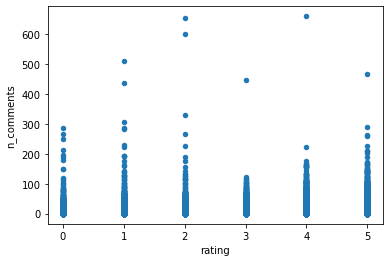

In [27]:
df.plot(kind='scatter', x='rating', y='n_comments')

<AxesSubplot:xlabel='n_votes', ylabel='n_comments'>

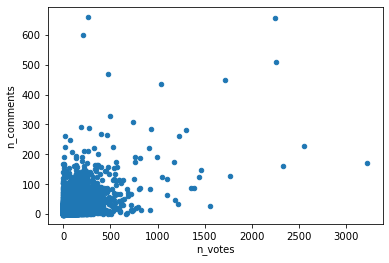

In [28]:
df.plot(kind='scatter', x='n_votes', y='n_comments')

## Normalize and Feature Scale the Data (Eren)

user_id  book_id  review_sentences  rating  timestamp  n_votes  n_comments  has_spoiler
False    False    False             False   False      False    False       False          604686
dtype: int64